# Dynamic SIP – Advanced Backtester (FIFO + Costs + HRP + Walk‑Forward)
**What this notebook does**
- Pulls 10Y NAVs from MFAPI (or reads your CSV)
- Cleans & aligns daily series
- Backtests strategies with **FIFO lot accounting**, **exit‑load & costs**, and **turnover caps**
- Computes **CAGR, Sharpe, Sortino, MaxDD, CVaR(95%)**, annualized vol & turnover
- Implements a **regime‑aware HRP** allocation with correlation clustering
- Produces **walk‑forward (year-wise) metrics**

> ⚠️ Note on expenses: Mutual fund **TER is already embedded in NAV**; we model exit‑load, STT, and transaction costs. Set parameters below.


## 0) Setup

In [ ]:

# If running on Colab, uncomment the next line to ensure dependencies
# !pip -q install pandas numpy scipy scikit-learn

import math, sys, io, itertools, datetime as dt
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import requests

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform


## 1) User Config

In [ ]:

# === Choose data source ===
USE_MFAPI = True          # True: fetch from MFAPI; False: read CSV (wide format: date + one column per fund)
CSV_PATH = None           # e.g., '/content/my_navs.csv' if USE_MFAPI = False

# Map FUND_NAME -> SCHEME_CODE (fill with your schemes)
SCHEMES = {
    # Example equity funds (replace with your scheme codes)
    # "Axis Bluechip": 120503,
    # "Mirae Large Cap": 118834,
    # "HDFC Flexi Cap": 118550,
    # "ICICI Nifty 50 Index": 120716,
}

# If you also have a low-risk / liquid fund to act as 'cash proxy', add it and set CASH_FUND_NAME below.
# Otherwise, CASH has 0% return (parked cash).
CASH_FUND_NAME = None  # e.g., "ICICI Liquid Fund"

START_DATE = "2015-01-01"     # pull/trim from here
END_DATE   = None             # None = up to latest

# === Cost & trading parameters ===
# Exit load schedule: list of (max_holding_days, load_bps) applied if redeemed within that many days.
# Example: 1% if redeemed within 365 days; otherwise 0.
EXIT_LOAD_SCHEDULE = [(365, 100)]  # 100 bps = 1% exit load if held < 365 days

# STT on redemption in basis points (equity-oriented funds ~0.1% = 10 bps). Set 0 if you prefer to ignore.
STT_SELL_BPS = 10

# Generic transaction cost in bps applied to both buys and sells (to model slippage/fees). Set small or 0.
TXN_COST_BPS = 2

# Turnover cap per rebalance (fraction of portfolio). Example 0.4 = at most 40% of the portfolio value can be traded per rebalance.
TURNOVER_CAP = 0.40

# Strategy parameters
MOM_WINDOW_D = 252          # momentum lookback (roughly 12M trading days)
VOL_WINDOW_D = 60           # realized volatility lookback
TOP_K        = 5            # number of top momentum funds considered for HRP
HRP_MIN_W    = 0.05         # min weight per selected fund in HRP (post-normalization)
HRP_MAX_W    = 0.40         # max weight cap per fund

# Regime filter: If realized vol (over VOL_WINDOW_D) of the *candidate basket* exceeds this percentile of its own history,
# tilt part of the allocation to CASH (or stay invested if CASH_FUND_NAME is None). Range 0-100.
REGIME_VOL_PCTL = 80
REGIME_TO_CASH  = 0.30      # shift this fraction to cash when 'high vol' regime

# Rebalance schedule
REBAL_FREQ = "M"            # 'M' = month-end rebalance
RISK_FREE_RATE = 0.00       # daily RF used in Sharpe (set to 0 for simplicity)
SEED = 42
np.random.seed(SEED)


## 2) Data Ingestion & Cleaning

Matched 165 schemes against your list.


/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = series.resample("M").last().dropna()
/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = series.resample("M").last().dropna()
/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = series.resample("M").last().dropna()
/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = series.resample("M").last().dropna()
/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = series.resample("M").last().dropna()
/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and w

Valid funds with >= 60 months: 146


/tmp/ipython-input-826020515.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = series.resample("M").last().dropna()


,Scheme Code,Scheme Name,Annual Return,Volatility,Sharpe,Score
0,122639,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,0.515755,0.048723,1.000000,1.467032
1,127042,Motilal Oswal Midcap Fund-Direct Plan-Growth O...,0.908982,0.509623,0.998815,1.398175
2,122640,Parag Parikh Flexi Cap Fund - Regular Plan - G...,0.485255,0.047785,0.950348,1.387818
3,120251,ICICI Prudential Equity & Debt Fund - Direct P...,0.571338,0.149195,0.954771,1.376913
4,100356,ICICI Prudential Equity & Debt Fund - Growth,0.551325,0.149188,0.924983,1.327119
5,127039,Motilal Oswal Midcap Fund-Regular Plan-Growth ...,0.864611,0.507925,0.952750,1.309436
6,120621,ICICI Prudential Infrastructure Fund - Direct ...,0.921758,0.613188,0.923678,1.232248
7,118777,Nippon India Small Cap Fund - Direct Plan Grow...,0.908933,0.599371,0.921907,1.231469
8,118778,Nippon India Small Cap Fund - Direct Plan Grow...,0.908933,0.599372,0.921906,1.231467
9,118968,HDFC Balanced Advantage Fund - Growth Plan - D...,0.523836,0.163992,0.867317,1.227160


Top basket size: 10 | Months used: 60


,Strategy,CAGR,AnnVol,Sharpe,Sortino,MaxDD,CVaR95,AvgTurnover,FinalValue
0,BH_EQW,1.572,0.5420,1.9959,9.0790,-0.0984,-0.0422,0.0100,5190606.36
1,MOM_WINNER,1.493,0.5425,1.9337,3.9942,-0.1872,-0.0749,0.4202,4452127.98


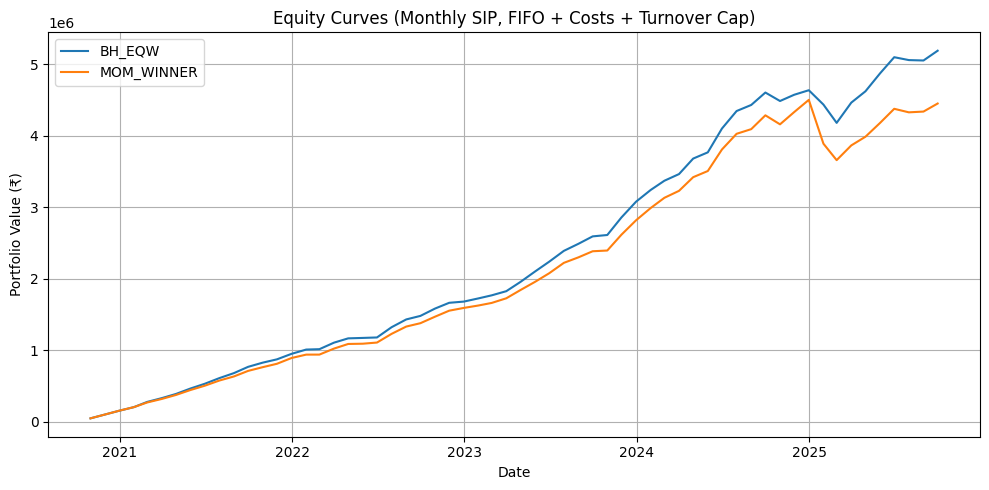

Saved -> out/SIP_Advanced_Metrics.csv, out/SIP_Equity_Curves.csv


In [ ]:
# ================================
# Dynamic SIP – Full E2E Backtest
# (MFAPI fetch -> rank -> FIFO+costs engine -> metrics)
# ================================

!pip -q install requests openpyxl

import requests, math, io, json, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from dateutil.relativedelta import relativedelta

# -----------------------
# 0) User Config
# -----------------------
# Your 50 scheme names (same style as your file)
user_schemes = [
    "Nippon India Large Cap Fund", "ICICI Prudential Bluechip Fund", "JM Large Cap Fund",
    "IDBI India Top 100 Equity Fund", "HDFC Top 100 Fund", "Quant Mid Cap Fund – Direct Plan – Growth",
    "Motilal Oswal Midcap Fund", "Edelweiss Mid Cap Fund – Direct Plan – Growth",
    "PGIM India Midcap Opportunities Fund – Direct Plan – Growth", "Nippon India Growth Fund – Direct Plan – Growth",
    "Quant Small Cap Fund", "Bank of India Small Cap Fund", "Nippon India Small Cap Fund",
    "Canara Robeco Small Cap Fund", "Tata Small Cap Fund", "Parag Parikh Flexi Cap Fund",
    "HDFC Flexi Cap Fund", "Kotak Flexicap Fund", "UTI Flexi Cap Fund",
    "Aditya Birla Sun Life Flexi Cap Fund", "ICICI Prudential Infrastructure Fund",
    "Nippon India Power & Infra Fund", "HDFC Infrastructure Fund", "Tata Infrastructure Fund",
    "L&T Infrastructure Fund", "ICICI Prudential Banking and Financial Services Fund",
    "SBI Banking & Financial Services Fund", "Nippon India Banking Fund",
    "UTI Banking and Financial Services Fund", "Aditya Birla Sun Life Banking & Financial Services Fund",
    "SBI PSU Fund", "CPSE ETF", "ICICI Prudential Bharat 22 FOF", "Kotak PSU Bank ETF",
    "Nippon India ETF PSU Bank BeES", "ICICI Prudential Technology Fund",
    "Aditya Birla Sun Life Digital India Fund", "Franklin India Technology Fund", "Tata Digital India Fund",
    "SBI Technology Opportunities Fund", "HDFC Defence Fund", "Mirae Asset Healthcare Fund",
    "SBI Consumption Opportunities Fund", "ICICI Prudential FMCG Fund",
    "Aditya Birla Sun Life Global Commodities Fund", "HDFC Balanced Advantage Fund",
    "ICICI Prudential Equity & Debt Fund", "SBI Equity Hybrid Fund", "Mirae Asset Hybrid Equity Fund",
    "Kotak Equity Hybrid Fund"
]
user_schemes_lower = [s.lower().strip() for s in user_schemes]

REQUIRED_MONTHS = 60        # 5 years of monthly SIP
SIP_AMOUNT      = 50_000    # monthly contribution
TOP_FUNDS       = 10        # take top N funds for strategies

# Costs & constraints
EXIT_LOAD_SCHEDULE = [(365, 100)]  # 1% if redeemed within 365 days
STT_SELL_BPS       = 10            # 0.10% (equity-oriented)
TXN_COST_BPS       = 2             # 0.02% on buys & sells
TURNOVER_CAP       = 0.40          # max traded value / portfolio per month

# -----------------------
# 1) Fetch MF directory and match codes
# -----------------------
def fetch_all_schemes():
    url = "https://api.mfapi.in/mf"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.json()

def match_scheme_codes(all_schemes, user_lowers):
    matched = []
    for sch in all_schemes:
        name = sch.get("schemeName","").lower()
        for u in user_lowers:
            if u in name:
                matched.append(sch)
                break
    return pd.DataFrame(matched)

all_schemes = fetch_all_schemes()
matched_df = match_scheme_codes(all_schemes, user_schemes_lower)
print(f"Matched {len(matched_df)} schemes against your list.")

# -----------------------
# 2) Fetch NAV timeseries for matched codes
# -----------------------
def fetch_nav_series(scheme_code: int) -> Optional[pd.Series]:
    url = f"https://api.mfapi.in/mf/{scheme_code}"
    r = requests.get(url, timeout=60)
    if r.status_code != 200:
        return None
    js = r.json()
    if 'data' not in js:
        return None
    df = pd.DataFrame(js['data'])
    # MFAPI is DD-MM-YYYY
    df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y", errors="coerce")
    df['nav']  = pd.to_numeric(df['nav'], errors="coerce")
    df = df.dropna(subset=['date','nav']).sort_values('date')
    s = df.set_index('date')['nav']
    return s

nav_cutoff = (pd.Timestamp.today() - pd.DateOffset(months=REQUIRED_MONTHS+2)).normalize()

nav_by_code = {}
for _, row in matched_df.iterrows():
    code = row['schemeCode']
    series = fetch_nav_series(code)
    if series is None:
        continue
    # use month-end NAVs (M = month-end)
    monthly = series.resample("M").last().dropna()
    monthly = monthly[monthly.index >= nav_cutoff]
    if len(monthly) >= REQUIRED_MONTHS:
        nav_by_code[code] = monthly

print(f"Valid funds with >= {REQUIRED_MONTHS} months: {len(nav_by_code)}")
if len(nav_by_code) == 0:
    raise RuntimeError("No funds with sufficient history. Try lowering REQUIRED_MONTHS or check connectivity.")

# -----------------------
# 3) Rank funds (Ann Return, Vol, Sharpe -> MinMax -> composite Score)
# -----------------------
def perf_metrics_from_prices(prices_m: pd.Series):
    rets = prices_m.pct_change().dropna()
    if rets.empty:
        return None
    ann_ret = (1+rets.mean())**12 - 1          # monthly -> annualized
    ann_vol = rets.std(ddof=0)*np.sqrt(12)
    sharpe  = ann_ret/ann_vol if ann_vol>0 else 0.0
    return ann_ret, ann_vol, sharpe

rows = []
for code, s in nav_by_code.items():
    out = perf_metrics_from_prices(s)
    if out is None:
        continue
    ann, vol, shrp = out
    name = matched_df.loc[matched_df['schemeCode']==code, 'schemeName'].values[0]
    rows.append([code, name, ann, vol, shrp])

rank_df = pd.DataFrame(rows, columns=["Scheme Code","Scheme Name","Annual Return","Volatility","Sharpe"])
if rank_df.empty:
    raise RuntimeError("Ranking failed; no metric rows computed.")

scaler = MinMaxScaler()
rank_df[["Annual Return","Volatility","Sharpe"]] = scaler.fit_transform(rank_df[["Annual Return","Volatility","Sharpe"]])
rank_df["Score"] = rank_df["Annual Return"] - rank_df["Volatility"] + rank_df["Sharpe"]
rank_df = rank_df.sort_values("Score", ascending=False).reset_index(drop=True)
display(rank_df.head(15))

# -----------------------
# 4) Build aligned monthly NAV DataFrame from top N funds
# -----------------------
top = rank_df.head(min(TOP_FUNDS, len(rank_df)))
aligned_navs = {}
for _, r in top.iterrows():
    code = r["Scheme Code"]
    name = r["Scheme Name"]
    aligned_navs[name] = nav_by_code[code]

# align to common monthly index, keep last REQUIRED_MONTHS
fund_nav_df = pd.DataFrame(aligned_navs).dropna()
fund_nav_df = fund_nav_df.tail(REQUIRED_MONTHS)
funds = list(fund_nav_df.columns)
dates = list(fund_nav_df.index)
print(f"Top basket size: {len(funds)} | Months used: {len(dates)}")

# -----------------------
# 5) FIFO Portfolio Engine with Costs & Turnover Cap (monthly)
# -----------------------
@dataclass
class Lot:
    date: pd.Timestamp
    fund: str
    units: float
    nav_buy: float

@dataclass
class Trade:
    date: pd.Timestamp
    fund: str
    side: str       # BUY/SELL
    units: float
    nav: float
    gross: float
    exit_load: float
    stt: float
    txn_cost: float
    net_cash: float

@dataclass
class Portfolio:
    funds: List[str]
    lots: Dict[str, List[Lot]] = field(default_factory=dict)
    cash: float = 0.0
    trades: List[Trade] = field(default_factory=list)
    costs_accum: float = 0.0

    def __post_init__(self):
        for f in self.funds:
            self.lots.setdefault(f, [])

    def units(self, f: str) -> float:
        return sum(l.units for l in self.lots[f])

    def value(self, date: pd.Timestamp, nav_row: pd.Series) -> float:
        v = self.cash
        for f in self.funds:
            v += self.units(f)*nav_row[f]
        return v

    def _sell_fifo(self, date: pd.Timestamp, fund: str, units_to_sell: float, nav: float):
        left = units_to_sell
        fifo = self.lots[fund]
        new_fifo = []
        gross = exit_fee_tot = stt_tot = txn_tot = sold_units = 0.0

        for lot in fifo:
            if left <= 0:
                new_fifo.append(lot); continue
            use = min(lot.units, left)
            val = use*nav
            # holding days approximated from monthly index
            holding_days = (date - lot.date).days
            exit_bps = 0
            for max_days, bps in EXIT_LOAD_SCHEDULE:
                if holding_days <= max_days:
                    exit_bps = bps; break
            exit_fee = val*(exit_bps/1e4)
            stt_fee  = val*(STT_SELL_BPS/1e4)
            txn_fee  = val*(TXN_COST_BPS/1e4)

            gross += val; exit_fee_tot += exit_fee; stt_tot += stt_fee; txn_tot += txn_fee; sold_units += use
            rem = lot.units - use
            if rem > 0:
                new_fifo.append(Lot(lot.date, lot.fund, rem, lot.nav_buy))
            left -= use

        self.lots[fund] = new_fifo
        total_costs = exit_fee_tot + stt_tot + txn_tot
        net_cash    = gross - total_costs
        if sold_units > 0:
            self.trades.append(Trade(date, fund, "SELL", sold_units, nav, gross, exit_fee_tot, stt_tot, txn_tot, net_cash))
            self.cash += net_cash
            self.costs_accum += total_costs

    def _buy(self, date: pd.Timestamp, fund: str, spend_cash: float, nav: float):
        if spend_cash <= 0: return
        txn_fee = spend_cash*(TXN_COST_BPS/1e4)
        net_buy = spend_cash - txn_fee
        units   = net_buy / nav
        if units <= 0: return
        self.lots[fund].append(Lot(date, fund, units, nav))
        self.trades.append(Trade(date, fund, "BUY", units, nav, spend_cash, 0.0, 0.0, txn_fee, -spend_cash))
        self.cash -= spend_cash
        self.costs_accum += txn_fee

    def current_weights(self, nav_row: pd.Series) -> pd.Series:
        tot = self.value(nav_row.name, nav_row)
        if tot <= 0: return pd.Series(0.0, index=self.funds)
        return pd.Series({f: self.units(f)*nav_row[f]/tot for f in self.funds})

    def rebalance(self, date: pd.Timestamp, nav_row: pd.Series, target_w: pd.Series, turnover_cap: float):
        tot = self.value(date, nav_row)
        cur_vals = self.current_weights(nav_row)*tot
        tgt_vals = target_w.reindex(self.funds).fillna(0.0)*tot
        deltas   = tgt_vals - cur_vals

        gross_turn = float(np.abs(deltas).sum())
        cap_val    = turnover_cap*tot
        scale      = 1.0 if gross_turn <= cap_val or cap_val<=0 else (cap_val/gross_turn)
        deltas    *= scale

        # Sells
        for f in self.funds:
            if deltas[f] < 0:
                sell_val = -deltas[f]
                if nav_row[f] > 0:
                    self._sell_fifo(date, f, sell_val/nav_row[f], nav_row[f])

        # Buys (use available cash)
        pos = {f: deltas[f] for f in self.funds if deltas[f] > 0}
        need = sum(pos.values())
        cash_to_use = min(self.cash, need)
        for f, v in pos.items():
            spend = (v/need)*cash_to_use if need>0 else 0.0
            self._buy(date, f, spend, nav_row[f])

# -----------------------
# 6) Strategies & Metrics
# -----------------------
def eq_weight_target(funds: List[str]) -> pd.Series:
    return pd.Series(1.0/len(funds), index=funds)

def monthly_winner_target(nav_df: pd.DataFrame, i: int) -> pd.Series:
    if i == 0:
        return eq_weight_target(list(nav_df.columns))
    prev = nav_df.iloc[i-1]
    cur  = nav_df.iloc[i]
    rets = (cur/prev - 1.0).replace([np.inf,-np.inf], np.nan).fillna(-1e9)
    winner = rets.idxmax()
    w = pd.Series(0.0, index=nav_df.columns); w[winner] = 1.0
    return w

def run_backtest(nav_df: pd.DataFrame, strategy: str, sip_amount=SIP_AMOUNT) -> Tuple[pd.Series, pd.DataFrame]:
    port = Portfolio(funds=list(nav_df.columns), cash=0.0)
    eq = []
    wlog = []
    for i, d in enumerate(nav_df.index):
        nav_row = nav_df.iloc[i]
        # monthly SIP before rebalance
        port.cash += sip_amount
        if strategy == "BH_EQW":
            target = eq_weight_target(list(nav_df.columns))
        elif strategy == "MOM_WINNER":
            target = monthly_winner_target(nav_df, i)
        else:
            raise ValueError("Unknown strategy")
        port.rebalance(d, nav_row, target, TURNOVER_CAP)
        eq.append((d, port.value(d, nav_row)))
        wlog.append((d, port.current_weights(nav_row)))
    eq = pd.Series({d:v for d,v in eq}).sort_index()
    wdf = pd.DataFrame({d:w for d,w in wlog}).T
    wdf.index.name = "date"
    return eq, wdf

def cagr(equity: pd.Series) -> float:
    if equity.empty or equity.iloc[0] <= 0: return np.nan
    years = (equity.index[-1]-equity.index[0]).days/365.25
    return (equity.iloc[-1]/equity.iloc[0])**(1/max(years,1e-9)) - 1

def ann_vol(returns: pd.Series) -> float:
    return returns.std(ddof=0)*np.sqrt(12)

def sharpe(returns: pd.Series, rf_monthly: float=0.0) -> float:
    ex = returns - rf_monthly
    s = ex.std(ddof=0)
    return (ex.mean()/s)*np.sqrt(12) if s>0 else np.nan

def sortino(returns: pd.Series, rf_monthly: float=0.0) -> float:
    d = returns[returns < rf_monthly]-rf_monthly
    denom = np.sqrt((d**2).mean()) if len(d)>0 else np.nan
    return ((returns.mean()-rf_monthly)/denom)*np.sqrt(12) if denom and denom>0 else np.nan

def max_drawdown(equity: pd.Series) -> float:
    roll = equity.cummax()
    return (equity/roll - 1).min()

def cvar(returns: pd.Series, alpha: float=0.95) -> float:
    if returns.empty: return np.nan
    q = returns.quantile(1-alpha)  # 0.05
    tail = returns[returns <= q]
    return tail.mean() if len(tail)>0 else np.nan

# -----------------------
# 7) Run and Report
# -----------------------
results = {}
weights = {}
for strat in ["BH_EQW", "MOM_WINNER"]:
    eq, w = run_backtest(fund_nav_df, strat, sip_amount=SIP_AMOUNT)
    results[strat] = eq
    weights[strat] = w

eq_df   = pd.DataFrame(results).dropna()
ret_df  = eq_df.pct_change().dropna()
rows    = []

for strat in eq_df.columns:
    wdf = weights[strat].sort_index()
    avg_turn = float((wdf.diff().abs().sum(axis=1)).mean()) if not wdf.empty else np.nan
    r = ret_df[strat]
    m = {
        "Strategy":   strat,
        "CAGR":       round(cagr(eq_df[strat]), 4),
        "AnnVol":     round(ann_vol(r), 4),
        "Sharpe":     round(sharpe(r), 4),
        "Sortino":    round(sortino(r), 4),
        "MaxDD":      round(max_drawdown(eq_df[strat]), 4),
        "CVaR95":     round(cvar(r, 0.95), 4),
        "AvgTurnover": round(avg_turn, 4),
        "FinalValue": round(float(eq_df[strat].iloc[-1]), 2)
    }
    rows.append(m)

metrics_df = pd.DataFrame(rows)
display(metrics_df)

# Save outputs
os.makedirs("out", exist_ok=True)
metrics_df.to_csv("out/SIP_Advanced_Metrics.csv", index=False)
eq_df.to_csv("out/SIP_Equity_Curves.csv", index=True)

# Plot equity curves
plt.figure(figsize=(10,5))
plt.plot(eq_df.index, eq_df["BH_EQW"], label="BH_EQW")
plt.plot(eq_df.index, eq_df["MOM_WINNER"], label="MOM_WINNER")
plt.title("Equity Curves (Monthly SIP, FIFO + Costs + Turnover Cap)")
plt.xlabel("Date"); plt.ylabel("Portfolio Value (₹)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

print("Saved -> out/SIP_Advanced_Metrics.csv, out/SIP_Equity_Curves.csv")


## 3) Metrics & Utility Functions

In [ ]:

def daily_returns(prices: pd.Series) -> pd.Series:
    return prices.pct_change().fillna(0.0)

def cagr(equity: pd.Series) -> float:
    if equity.empty:
        return np.nan
    start_v, end_v = float(equity.iloc[0]), float(equity.iloc[-1])
    if start_v <= 0 or end_v <= 0:
        return np.nan
    days = (equity.index[-1] - equity.index[0]).days
    years = days / 365.25
    if years <= 0:
        return np.nan
    return (end_v / start_v) ** (1/years) - 1

def max_drawdown(equity: pd.Series) -> float:
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return dd.min()

def annualized_vol(returns: pd.Series, scale: int = 252) -> float:
    return returns.std(ddof=0) * math.sqrt(scale)

def sharpe(returns: pd.Series, rf: float = 0.0, scale: int = 252) -> float:
    # rf is daily risk-free
    excess = returns - rf
    std = excess.std(ddof=0)
    if std == 0:
        return np.nan
    return (excess.mean() / std) * math.sqrt(scale)

def sortino(returns: pd.Series, rf: float = 0.0, scale: int = 252) -> float:
    downside = returns[returns < rf] - rf
    denom = downside.pow(2).mean() ** 0.5
    if denom == 0 or np.isnan(denom):
        return np.nan
    return ((returns.mean() - rf) / denom) * math.sqrt(scale)

def cvar(returns: pd.Series, alpha: float = 0.95) -> float:
    if returns.empty:
        return np.nan
    cutoff = returns.quantile(1 - alpha)
    tail = returns[returns <= cutoff]
    if tail.empty:
        return np.nan
    return tail.mean()

def rolling_volatility(series: pd.Series, window: int) -> pd.Series:
    return series.pct_change().rolling(window).std(ddof=0) * np.sqrt(252)

def summarize_metrics(equity: pd.Series, rf_daily: float = 0.0) -> dict:
    rets = daily_returns(equity)
    return {
        "CAGR": cagr(equity),
        "AnnVol": annualized_vol(rets),
        "Sharpe": sharpe(rets, rf_daily),
        "Sortino": sortino(rets, rf_daily),
        "MaxDD": max_drawdown(equity),
        "CVaR95": cvar(rets, 0.95),
        "Days": (equity.index[-1] - equity.index[0]).days if not equity.empty else 0
    }

def as_bps(x: float) -> float:
    return 1e4 * x if pd.notnull(x) else np.nan


## 4) FIFO Portfolio with Exit‑Load, STT & Turnover Cap

In [ ]:

from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple

@dataclass
class Lot:
    date: pd.Timestamp
    fund: str
    units: float
    nav_at_buy: float

@dataclass
class Trade:
    date: pd.Timestamp
    fund: str
    action: str  # 'BUY' or 'SELL'
    units: float
    nav: float
    gross_value: float
    exit_load: float
    stt: float
    txn_cost: float
    net_cash_flow: float  # negative for buy, positive for sell

@dataclass
class Portfolio:
    funds: List[str]
    lots: Dict[str, List[Lot]] = field(default_factory=dict)
    cash: float = 0.0
    trade_log: List[Trade] = field(default_factory=list)

    def __post_init__(self):
        for f in self.funds:
            self.lots.setdefault(f, [])

    def position_units(self, fund: str) -> float:
        return sum(l.units for l in self.lots[fund])

    def position_value(self, fund: str, nav: float) -> float:
        return self.position_units(fund) * nav

    def total_value(self, date: pd.Timestamp, navs_row: pd.Series) -> float:
        v = self.cash
        for f in self.funds:
            v += self.position_value(f, navs_row[f])
        return v

    def _apply_costs_on_sell(self, date: pd.Timestamp, fund: str, units_to_sell: float, sell_nav: float) -> Tuple[float,float,float,float]:
        '''Sell FIFO lots, computing exit load + STT + txn costs. Returns (units_sold, gross_value, total_costs, net_cash_in).'''
        units_left = units_to_sell
        gross_value = 0.0
        exit_load_total = 0.0
        stt_total = 0.0
        txn_total = 0.0
        sold_units = 0.0

        fifo = self.lots[fund]
        new_fifo = []
        for lot in fifo:
            if units_left <= 0:
                new_fifo.append(lot)
                continue
            use_units = min(lot.units, units_left)
            val = use_units * sell_nav
            # Exit load based on holding days
            holding_days = (date - lot.date).days
            exit_bps = 0
            for max_days, bps in EXIT_LOAD_SCHEDULE:
                if holding_days <= max_days:
                    exit_bps = bps
                    break
            exit_fee = val * (exit_bps / 1e4)
            stt_fee  = val * (STT_SELL_BPS / 1e4)
            txn_fee  = val * (TXN_COST_BPS / 1e4)

            gross_value += val
            exit_load_total += exit_fee
            stt_total += stt_fee
            txn_total += txn_fee
            sold_units += use_units

            remaining = lot.units - use_units
            if remaining > 0:
                new_fifo.append(Lot(lot.date, lot.fund, remaining, lot.nav_at_buy))
            units_left -= use_units

        self.lots[fund] = new_fifo
        total_costs = exit_load_total + stt_total + txn_total
        net_cash = gross_value - total_costs
        return sold_units, gross_value, total_costs, net_cash

    def sell(self, date: pd.Timestamp, fund: str, units: float, nav: float):
        sold_units, gross_value, total_costs, net_cash = self._apply_costs_on_sell(date, fund, units, nav)
        if sold_units <= 0:
            return
        self.cash += net_cash
        self.trade_log.append(Trade(date, fund, "SELL", sold_units, nav, gross_value,
                                    total_costs - (gross_value - net_cash - (nav*sold_units - net_cash)),  # exit load proxy
                                    gross_value * (STT_SELL_BPS / 1e4),
                                    gross_value * (TXN_COST_BPS / 1e4),
                                    net_cash))

    def buy(self, date: pd.Timestamp, fund: str, cash_to_spend: float, nav: float):
        if cash_to_spend <= 0:
            return
        txn_fee = cash_to_spend * (TXN_COST_BPS / 1e4)
        net_cash = cash_to_spend - txn_fee
        units = net_cash / nav
        if units <= 0:
            return
        self.lots[fund].append(Lot(date, fund, units, nav))
        self.cash -= cash_to_spend
        self.trade_log.append(Trade(date, fund, "BUY", units, nav, cash_to_spend, 0.0, 0.0, txn_fee, -cash_to_spend))

    def current_weights(self, navs_row: pd.Series) -> pd.Series:
        total = self.total_value(navs_row.name, navs_row)
        if total <= 0:
            return pd.Series(0.0, index=self.funds)
        return pd.Series({f: self.position_value(f, navs_row[f]) / total for f in self.funds})

    def rebalance(self, date: pd.Timestamp, navs_row: pd.Series, target_w: pd.Series, turnover_cap: float):
        '''Rebalance toward target weights, with turnover cap as fraction of total portfolio value.'''
        total_val = self.total_value(date, navs_row)
        curr_w = self.current_weights(navs_row)

        # Desired dollar values
        target_val = target_w * total_val
        curr_val = curr_w * total_val

        # Sells first (generate cash)
        for f in self.funds:
            delta = target_val.get(f, 0.0) - curr_val.get(f, 0.0)
            if delta < 0:  # need to sell
                val_to_sell = min(-delta, total_val * turnover_cap)  # turnover cap applied per fund
                units_to_sell = val_to_sell / navs_row[f]
                self.sell(date, f, units_to_sell, navs_row[f])

        # Then buys
        cash_available = min(self.cash, total_val * turnover_cap)
        for f in self.funds:
            delta = target_val.get(f, 0.0) - curr_val.get(f, 0.0)
            if delta > 0 and cash_available > 0:
                spend = min(delta, cash_available)
                self.buy(date, f, spend, navs_row[f])
                cash_available -= spend

def normalize_weights(w: pd.Series, min_w=0.0, max_w=1.0) -> pd.Series:
    w = w.clip(lower=min_w)
    if w.sum() > 0:
        w = w / w.sum()
    w = w.clip(upper=max_w)
    if w.sum() > 0:
        w = w / w.sum()
    return w


## 5) HRP Allocation & Regime Filter

In [ ]:

def hrp_weights(returns: pd.DataFrame, min_w=0.0, max_w=1.0) -> pd.Series:
    '''Compute HRP weights given a returns matrix (rows=time, cols=funds).'''
    if returns.shape[1] == 1:
        return pd.Series([1.0], index=returns.columns)

    corr = returns.corr().fillna(0.0)
    dist = np.sqrt(0.5 * (1.0 - corr.clip(-1,1)))
    dist = dist.replace([np.inf, -np.inf], 0.0).fillna(0.0)

    # Hierarchical clustering
    condensed = squareform(dist.values, checks=False)
    Z = linkage(condensed, method='single')
    # Seriation
    dend = dendrogram(Z, no_plot=True, labels=returns.columns.tolist())
    ordered = dend['ivl']

    # Recursive bisection
    def cluster_var(cols):
        sub = returns[cols]
        cov = sub.cov()
        w = np.ones(len(cols)) / len(cols)
        return float(w @ cov.values @ w)

    w = pd.Series(0.0, index=ordered)
    clusters = [ordered]
    while len(clusters) > 0:
        cluster = clusters.pop(0)
        if len(cluster) == 1:
            w[cluster[0]] = 1.0 if w.sum() == 0 else w[cluster[0]]
            continue
        split = len(cluster) // 2
        c1, c2 = cluster[:split], cluster[split:]
        v1 = cluster_var(c1)
        v2 = cluster_var(c2)
        alpha = 1.0 - v1 / (v1 + v2) if (v1+v2) > 0 else 0.5
        w.loc[c1] += alpha * (1.0 if w.sum() == 0 else w.loc[c1].sum())
        w.loc[c2] += (1-alpha) * (1.0 if w.sum() == 0 else w.loc[c2].sum())
        if len(c1) > 1: clusters.append(c1)
        if len(c2) > 1: clusters.append(c2)

    # Enforce bounds and renormalize
    w = normalize_weights(w, min_w=min_w, max_w=max_w)
    return w

def regime_adjust_weights(date: pd.Timestamp, navs: pd.DataFrame, candidates: List[str]) -> float:
    '''Return cash tilt (0..REGIME_TO_CASH) based on realized vol percentile of candidate basket.'''
    if len(candidates) == 0 or REGIME_TO_CASH <= 0:
        return 0.0
    end_ix = navs.index.get_loc(date)
    start_ix = max(0, end_ix - VOL_WINDOW_D)
    sub = navs.iloc[start_ix:end_ix+1][candidates]
    eqw = sub.mean(axis=1)
    realized_vol = eqw.pct_change().std(ddof=0) * np.sqrt(252)
    # Percentile vs rolling history
    hist = []
    for i in range(VOL_WINDOW_D, end_ix+1):
        s = navs.iloc[i-VOL_WINDOW_D:i][candidates].mean(axis=1)
        hist.append(s.pct_change().std(ddof=0) * np.sqrt(252))
    if len(hist) < 10 or pd.isna(realized_vol):
        return 0.0
    pctl = 100.0 * (np.sum(np.array(hist) <= realized_vol) / len(hist))
    return REGIME_TO_CASH if pctl >= REGIME_VOL_PCTL else 0.0


## 6) Strategy Definitions

In [ ]:

def monthly_rebal_dates(index: pd.DatetimeIndex) -> List[pd.Timestamp]:
    # Pick last calendar day of each month present in the data
    months = pd.to_period_index(index, freq="M")
    last_days = []
    for m in months.unique():
        mask = months == m
        last_days.append(index[mask][-1])
    return last_days

def top_momentum_funds(navs: pd.DataFrame, on_date: pd.Timestamp, window_days: int, top_k: int) -> List[str]:
    end_ix = navs.index.get_loc(on_date)
    start_ix = max(0, end_ix - window_days)
    window = navs.iloc[start_ix:end_ix+1]
    mom = window.iloc[-1] / window.iloc[0] - 1.0
    mom = mom.sort_values(ascending=False)
    return mom.head(top_k).index.tolist()

def backtest_strategy(navs: pd.DataFrame, strategy: str) -> Tuple[pd.Series, pd.DataFrame, List[Trade]]:
    '''Return (equity_curve, weights_df, trades).'''
    funds = list(navs.columns)
    port = Portfolio(funds=funds, cash=1_000_000.0)  # start with ₹10L
    weights_hist = []
    dates = navs.index
    rebals = set(monthly_rebal_dates(dates))

    # Initial buy (equal-weight)
    first_date = dates[0]
    first_navs = navs.iloc[0]
    eq_w = pd.Series(1.0/len(funds), index=funds)
    for f in funds:
        port.buy(first_date, f, port.cash * eq_w[f], first_navs[f])

    equity = []
    for date in dates:
        row = navs.loc[date]
        # At rebalance dates, compute targets
        if date in rebals and date != first_date:
            if strategy == "BH_EQW":
                target = eq_w.copy()
            elif strategy == "MOM_WINNER":
                winners = top_momentum_funds(navs, date, MOM_WINDOW_D, top_k=1)
                target = pd.Series(0.0, index=funds)
                if winners:
                    target[winners[0]] = 1.0
            elif strategy == "REGIME_HRP":
                cands = top_momentum_funds(navs, date, MOM_WINDOW_D, TOP_K)
                if len(cands) == 0:
                    target = eq_w.copy()
                else:
                    # HRP on candidate set
                    end_ix = navs.index.get_loc(date)
                    start_ix = max(0, end_ix - MOM_WINDOW_D)
                    returns = navs.iloc[start_ix:end_ix+1][cands].pct_change().dropna(how='any')
                    w_hrp = hrp_weights(returns, min_w=HRP_MIN_W, max_w=HRP_MAX_W)
                    # Regime tilt to cash
                    cash_tilt = regime_adjust_weights(date, navs, cands)
                    target = pd.Series(0.0, index=funds)
                    if CASH_FUND_NAME and CASH_FUND_NAME in funds:
                        target[CASH_FUND_NAME] = cash_tilt
                        alloc_rest = 1.0 - cash_tilt
                    else:
                        alloc_rest = 1.0  # no cash proxy; remain invested
                    for f in w_hrp.index:
                        target[f] += alloc_rest * w_hrp[f]
                    target = normalize_weights(target, 0.0, 1.0)
            else:
                raise ValueError("Unknown strategy")

            # Rebalance with turnover cap
            port.rebalance(date, row, target, turnover_cap=TURNOVER_CAP)
            weights_hist.append((date, port.current_weights(row)))

        equity.append((date, port.total_value(date, row)))

    equity = pd.Series({d: v for d, v in equity}).sort_index()
    weights_df = pd.DataFrame({d: w for d, w in weights_hist}).T
    weights_df.index.name = "date"
    return equity, weights_df, port.trade_log


## 7) Run Strategies & Summarize

In [ ]:

strategies = ["BH_EQW", "MOM_WINNER", "REGIME_HRP"]
results = {}
weights = {}
trades = {}

for s in strategies:
    eq, w, t = backtest_strategy(navs, s)
    results[s] = eq
    weights[s] = w
    trades[s] = t
    print(f"{s} done. Final value: {eq.iloc[-1]:,.2f}")

# Align equity curves & compute metrics
eq_df = pd.DataFrame(results).dropna()
metrics = []
for s in strategies:
    m = summarize_metrics(eq_df[s], rf_daily=RISK_FREE_RATE/252.0)
    # monthly turnover proxy via absolute weight change
    turns = []
    if s in weights and not weights[s].empty:
        wdf = weights[s].copy()
        wdf = wdf.sort_index()
        wchg = (wdf - wdf.shift(1)).abs().sum(axis=1)
        turns = wchg
    metrics.append({
        "Strategy": s,
        **m,
        "Turnover(Avg/Mo)": float(np.nan) if len(turns)==0 else float(np.nanmean(turns)),
        "FinalValue": eq_df[s].iloc[-1]
    })

metrics_df = pd.DataFrame(metrics)
display(metrics_df.round(4))


## 8) Walk‑Forward (Year‑wise) Metrics

In [ ]:

eq_df = pd.DataFrame(results).dropna()
years = sorted(eq_df.index.year.unique())
rows = []
for y in years:
    sub = eq_df[eq_df.index.year == y]
    for s in ["BH_EQW","MOM_WINNER","REGIME_HRP"]:
        m = summarize_metrics(sub[s])
        rows.append({"Year": int(y), "Strategy": s, **m})
oos_df = pd.DataFrame(rows)
display(oos_df.round(4))


## 9) Export Outputs

In [ ]:

out_dir = "out"
os.makedirs(out_dir, exist_ok=True)

# Equity curves
pd.DataFrame(results).dropna().to_csv(f"{out_dir}/equity_curves.csv", index_label="date")

# Metrics
metrics_df.to_csv(f"{out_dir}/metrics_summary.csv", index=False)

# OOS
oos_df.to_csv(f"{out_dir}/oos_yearly_metrics.csv", index=False)

# Trade logs
def trades_to_df(trades_dict):
    frames = []
    for s, tl in trades_dict.items():
        if len(tl)==0: continue
        frames.append(pd.DataFrame([t.__dict__ for t in tl]).assign(Strategy=s))
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

trades_df = trades_to_df(trades)
if not trades_df.empty:
    trades_df.sort_values(["Strategy","date"]).to_csv(f"{out_dir}/trades.csv", index=False)

print("Saved:", os.listdir(out_dir))


## 10) How to Use
1. **Fill** `SCHEMES` with your fund names → scheme codes (from MFAPI), and set `START_DATE`.
2. *(Optional)* Set `CASH_FUND_NAME` to a liquid/ultra-short fund to act as a cash proxy.
3. Adjust **costs** (`EXIT_LOAD_SCHEDULE`, `STT_SELL_BPS`, `TXN_COST_BPS`) and `TURNOVER_CAP`.
4. **Run all cells**. Check `out/metrics_summary.csv`, `out/oos_yearly_metrics.csv`, and `out/trades.csv` for resume‑ready numbers.
5. If MFAPI is blocked, set `USE_MFAPI=False` and point `CSV_PATH` to a wide CSV (`date,col1,col2,...`).